In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier


In [12]:
import pandas as pd
import os

path = "/Users/ethanada/Desktop/ActuarAI_streamlit/data/insurance_fraud_dataset.csv"

# Petite vérification de sécurité pour confirmer que le fichier est bien là
if os.path.exists(path):
    df = pd.read_csv(path, sep=";")
    print("Shape:", df.shape)
    print(df.head())

Shape: (1000, 40)
   months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       17/10/2014           OH   
1                 228   42         342868       27/06/2006           IN   
2                 134   29         687698       06/09/2000           OH   
3                 256   41         227811       25/05/1990           IL   
4                 228   44         367455       06/06/2014           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... police_report_available total_claim_amount injury_claim  \
0      

In [14]:
# distribution de la target
print(df["fraud_reported"].value_counts())
print(df["fraud_reported"].value_counts(normalize=True))

# valeurs manquantes (NaN)
missing_rate = df.isna().mean().sort_values(ascending=False)
display(missing_rate.head(15))


fraud_reported
N    753
Y    247
Name: count, dtype: int64
fraud_reported
N    0.753
Y    0.247
Name: proportion, dtype: float64


_c39                           1.000
authorities_contacted          0.091
fraud_reported                 0.000
auto_year                      0.000
incident_state                 0.000
incident_city                  0.000
incident_location              0.000
incident_hour_of_the_day       0.000
number_of_vehicles_involved    0.000
property_damage                0.000
bodily_injuries                0.000
witnesses                      0.000
age                            0.000
total_claim_amount             0.000
injury_claim                   0.000
dtype: float64

In [16]:
# Ces colonnes sont quasi-uniques (100% ou ~100% uniques) -> elles agissent comme des identifiants.
# Les garder fait souvent sur-apprendre le modèle (overfitting) car il peut "mémoriser" chaque ligne.
to_drop = ["policy_number", "incident_location", "insured_zip", "_c39"]  

df2 = df.drop(columns=[c for c in to_drop if c in df.columns]).copy()

print("\nAprès drop des colonnes identifiantes/inutiles :", df2.shape)




Après drop des colonnes identifiantes/inutiles : (1000, 36)


In [20]:
cols_with_question_mark = ["property_damage", "police_report_available", "collision_type"]

for col in cols_with_question_mark:
    if col in df2.columns:
        df2[col] = df2[col].replace("?", np.nan)

# Vérification rapide : combien de NaN par colonne (après remplacement de '?')
print("\nTop colonnes avec NaN après remplacement de '?' :")
display(df2.isna().mean().sort_values(ascending=False).head(10))


Top colonnes avec NaN après remplacement de '?' :


property_damage            0.360
police_report_available    0.343
collision_type             0.178
authorities_contacted      0.091
auto_model                 0.000
auto_make                  0.000
vehicle_claim              0.000
property_claim             0.000
injury_claim               0.000
total_claim_amount         0.000
dtype: float64

In [22]:
# FEATURE ENGINEERING: dates -> variables numériques utiles

# Les dates brutes ont souvent trop de valeurs uniques 
# L'information utile, c'est plutôt :
# - l'année / le mois
# - l'ancienneté entre la souscription et l'incident (variable très informative en fraude)
df3 = df2.copy()

# Conversion en datetime (errors='coerce' => si parsing impossible, on obtient NaT)
if "policy_bind_date" in df3.columns:
    df3["policy_bind_date"] = pd.to_datetime(df3["policy_bind_date"], errors="coerce")

if "incident_date" in df3.columns:
    df3["incident_date"] = pd.to_datetime(df3["incident_date"], errors="coerce")

# Création de features dérivées
if "policy_bind_date" in df3.columns:
    df3["policy_bind_year"] = df3["policy_bind_date"].dt.year
    df3["policy_bind_month"] = df3["policy_bind_date"].dt.month

if "incident_date" in df3.columns:
    df3["incident_year"] = df3["incident_date"].dt.year
    df3["incident_month"] = df3["incident_date"].dt.month
    df3["incident_day"] = df3["incident_date"].dt.day

# Variable "ancienneté en jours" entre souscription et incident
if "policy_bind_date" in df3.columns and "incident_date" in df3.columns:
    df3["days_between_bind_and_incident"] = (df3["incident_date"] - df3["policy_bind_date"]).dt.days

# Une fois les infos extraites, on supprime les dates brutes
df3 = df3.drop(columns=[c for c in ["policy_bind_date", "incident_date"] if c in df3.columns])

print("\nAprès feature engineering dates :", df3.shape)
display(df3.head())


Après feature engineering dates : (1000, 40)


/var/folders/4r/0hfn0b9j3255jq98_glsbl080000gn/T/ipykernel_25626/2603891741.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df3["policy_bind_date"] = pd.to_datetime(df3["policy_bind_date"], errors="coerce")
/var/folders/4r/0hfn0b9j3255jq98_glsbl080000gn/T/ipykernel_25626/2603891741.py:14: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df3["incident_date"] = pd.to_datetime(df3["incident_date"], errors="coerce")


,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,auto_make,auto_model,auto_year,fraud_reported,policy_bind_year,policy_bind_month,incident_year,incident_month,incident_day,days_between_bind_and_incident
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,Saab,92x,2004,Y,2014,10,2015,1,25,100
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,Mercedes,E400,2007,Y,2006,6,2015,1,21,3130
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,Dodge,RAM,2007,N,2000,9,2015,2,22,5282
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,Chevrolet,Tahoe,2014,Y,1990,5,2015,1,10,8996
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,Accura,RSX,2009,N,2014,6,2015,2,17,256


In [20]:
#  DEFINE X (features) and y (target)

# On transforme la target 'fraud_reported' en binaire :
# - 1 = fraude (Y)
# - 0 = non fraude (N)
y = (df3["fraud_reported"] == "Y").astype(int)
X = df3.drop(columns=["fraud_reported"])

print("\nTaux de fraude global :", y.mean())



Taux de fraude global : 0.247


In [22]:
#  TRAIN/TEST SPLIT (stratifié)

# Stratify=y garantit que le % de fraude est similaire dans train et test.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("\nTrain shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Fraud rate train:", y_train.mean(), "| Fraud rate test:", y_test.mean())



Train shape: (800, 39) | Test shape: (200, 39)
Fraud rate train: 0.2475 | Fraud rate test: 0.245


In [24]:
#  PREPROCESSING PIPELINE (numériques vs catégorielles)

# On identifie les colonnes numériques et catégorielles automatiquement.
# Colonnes numériques (int/float)
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Colonnes catégorielles : inclure explicitement "object" ET "string"
cat_cols = X_train.select_dtypes(include=["object", "string"]).columns.tolist()


# Pipeline numérique:
# imputation médiane (robuste aux outliers)
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Pipeline catégoriel:
#  imputation de la modalité la plus fréquente
# one-hot encoding pour transformer les catégories en variables 0/1
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# On combine les deux pipelines dans un ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"  # tout le reste est ignoré
)

print("\n# Num cols:", len(num_cols), "| # Cat cols:", len(cat_cols))


# Num cols: 17 | # Cat cols: 17


In [38]:
# MODEL 1: Logistic Regression (baseline)

# Baseline simple + interprétable.
# class_weight='balanced' aide quand la classe "fraude" est moins fréquente.
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

log_reg.fit(X_train, y_train)

# Probabilité prédite de la classe fraude (1)
proba_lr = log_reg.predict_proba(X_test)[:, 1]

# Décision au seuil 0.5 (on améliorera ce seuil plus tard)
pred_lr = (proba_lr >= 0.5).astype(int)

print("\n=== Logistic Regression ===")
print("ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("PR-AUC :", average_precision_score(y_test, proba_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_lr))
print(classification_report(y_test, pred_lr, digits=3))


=== Logistic Regression ===
ROC-AUC: 0.6000810920394648
PR-AUC : 0.2968709588495757
Confusion matrix:
 [[75 76]
 [19 30]]
              precision    recall  f1-score   support

           0      0.798     0.497     0.612       151
           1      0.283     0.612     0.387        49

    accuracy                          0.525       200
   macro avg      0.540     0.554     0.500       200
weighted avg      0.672     0.525     0.557       200



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)


# MODEL 2: HGB (sparse -> dense) + seuil optimisé

# 1) Convert sparse -> dense (obligatoire pour HGB)
to_dense = FunctionTransformer(lambda x: x.toarray() if hasattr(x, "toarray") else x)

# 2) Pipeline
hgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("to_dense", to_dense),
    ("model", HistGradientBoostingClassifier(random_state=42))
])

# 3) Fit + proba
hgb.fit(X_train, y_train)
proba_hgb = hgb.predict_proba(X_test)[:, 1]

# 4) Métriques "threshold-free"
print("\n=== HistGradientBoosting (sparse->dense) ===")
print("ROC-AUC:", roc_auc_score(y_test, proba_hgb))
print("PR-AUC :", average_precision_score(y_test, proba_hgb))

# 5) Confusion matrix au seuil 0.5 (pour comparaison)
pred_05 = (proba_hgb >= 0.5).astype(int)
cm_05 = confusion_matrix(y_test, pred_05)

print("\n--- Seuil 0.50 ---")
print("Confusion matrix:\n", cm_05)
print(classification_report(y_test, pred_05, digits=3))

# 6) Recherche du meilleur seuil (max F1) -> pour raccorder avec tes graphiques
y_true = np.array(y_test)
y_score = np.array(proba_hgb)

thresholds = np.linspace(0.01, 0.99, 99)
rows = []
for t in thresholds:
    pred = (y_score >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_true, pred, zero_division=0),
        "recall": recall_score(y_true, pred, zero_division=0),
        "f1": f1_score(y_true, pred, zero_division=0),
    })

df_thr = pd.DataFrame(rows)
best_idx = df_thr["f1"].idxmax()
best_t = float(df_thr.loc[best_idx, "threshold"])
best_row = df_thr.loc[best_idx].to_dict()

# 7) Confusion matrix au meilleur seuil (celui des graphes)
pred_best = (y_score >= best_t).astype(int)
cm_best = confusion_matrix(y_test, pred_best)

print("\n--- Seuil optimal (max F1) ---")
print("best_t =", round(best_t, 3))
print("Scores au best_t:", {k: round(v, 3) for k, v in best_row.items()})
print("Confusion matrix:\n", cm_best)
print(classification_report(y_test, pred_best, digits=3))



=== HistGradientBoosting (sparse->dense) ===
ROC-AUC: 0.8288957967292877
PR-AUC : 0.588615874542302

--- Seuil 0.50 ---
Confusion matrix:
 [[134  17]
 [ 20  29]]
              precision    recall  f1-score   support

           0      0.870     0.887     0.879       151
           1      0.630     0.592     0.611        49

    accuracy                          0.815       200
   macro avg      0.750     0.740     0.745       200
weighted avg      0.811     0.815     0.813       200


--- Seuil optimal (max F1) ---
best_t = 0.14
Scores au best_t: {'threshold': 0.14, 'precision': 0.635, 'recall': 0.816, 'f1': 0.714}
Confusion matrix:
 [[128  23]
 [  9  40]]
              precision    recall  f1-score   support

           0      0.934     0.848     0.889       151
           1      0.635     0.816     0.714        49

    accuracy                          0.840       200
   macro avg      0.785     0.832     0.802       200
weighted avg      0.861     0.840     0.846       200



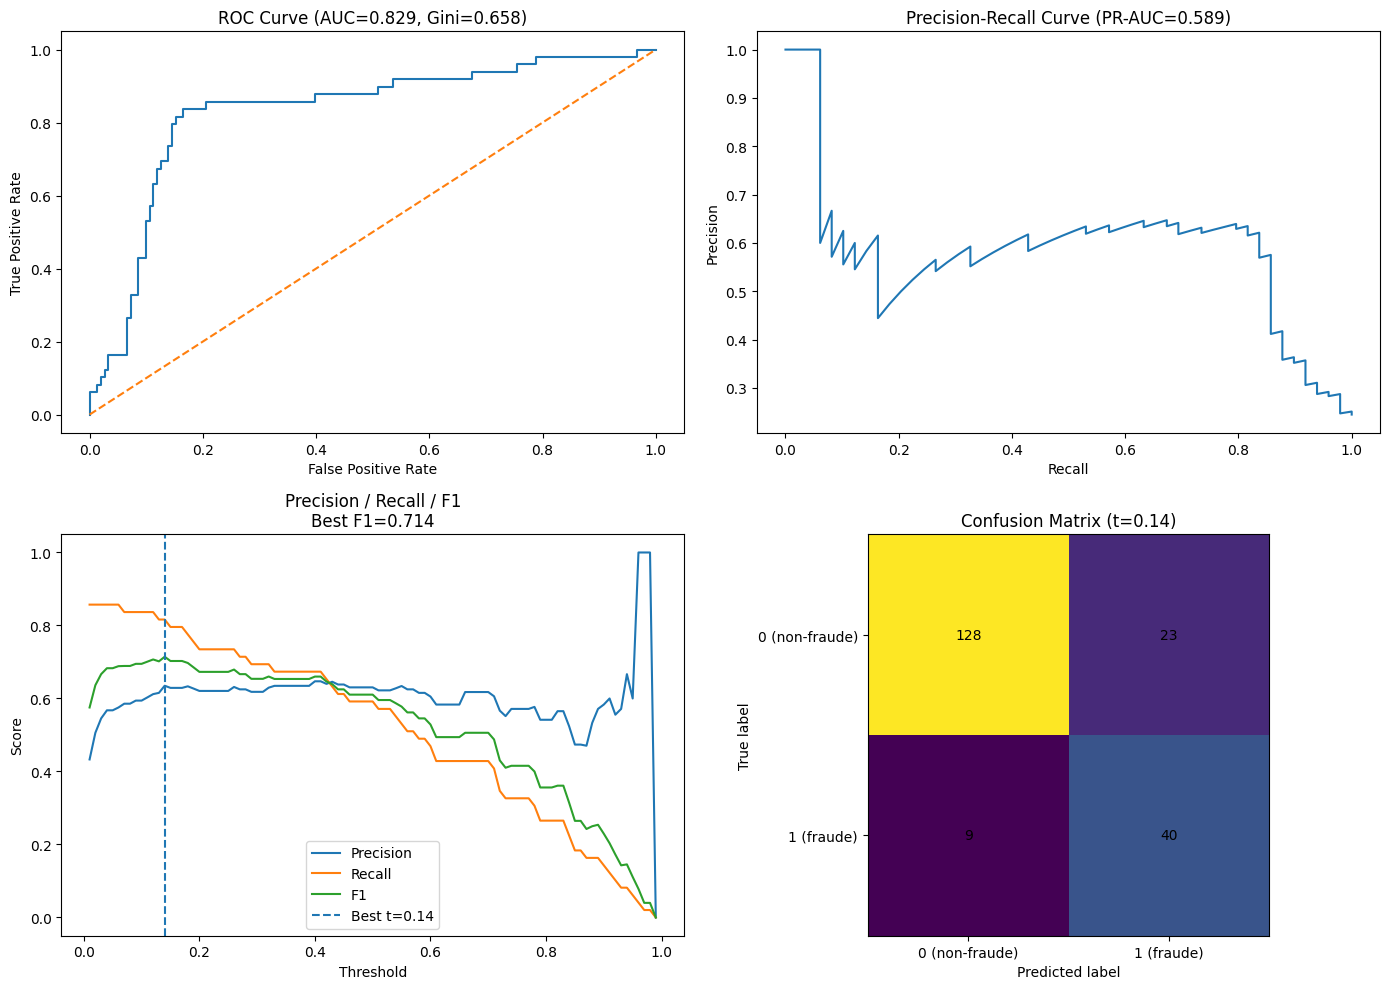

Meilleur seuil (max F1): 0.14
Scores au meilleur seuil:
threshold    0.140000
precision    0.634921
recall       0.816327
f1           0.714286
Name: 13, dtype: float64


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    average_precision_score,
    precision_score, recall_score, f1_score,
    confusion_matrix
)


# Safety check

required_vars = ["y_test", "proba_hgb"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Variables manquantes dans le notebook: {missing}. "
        "Assure-toi d'avoir déjà exécuté la cellule du modèle HGB qui produit 'proba_hgb'."
    )

y_true = np.array(y_test)
y_score = np.array(proba_hgb)


# 1) ROC + Gini

fpr, tpr, roc_thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
gini = 2 * roc_auc - 1


# 2) Precision-Recall

precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
pr_auc = average_precision_score(y_true, y_score)


# 3) Threshold tuning

thresholds = np.linspace(0.01, 0.99, 99)
rows = []
for t in thresholds:
    pred = (y_score >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_true, pred, zero_division=0),
        "recall": recall_score(y_true, pred, zero_division=0),
        "f1": f1_score(y_true, pred, zero_division=0),
    })

df_thr = pd.DataFrame(rows)
best_idx = df_thr["f1"].idxmax()
best_t = float(df_thr.loc[best_idx, "threshold"])
best_f1 = float(df_thr.loc[best_idx, "f1"])


# 4) Confusion matrix

pred_best = (y_score >= best_t).astype(int)
cm = confusion_matrix(y_true, pred_best)


# PLOTS (2x2 layout)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

#  ROC 
axs[0, 0].plot(fpr, tpr)
axs[0, 0].plot([0, 1], [0, 1], linestyle="--")
axs[0, 0].set_xlabel("False Positive Rate")
axs[0, 0].set_ylabel("True Positive Rate")
axs[0, 0].set_title(f"ROC Curve (AUC={roc_auc:.3f}, Gini={gini:.3f})")

#  Precision-Recall 
axs[0, 1].plot(recall, precision)
axs[0, 1].set_xlabel("Recall")
axs[0, 1].set_ylabel("Precision")
axs[0, 1].set_title(f"Precision-Recall Curve (PR-AUC={pr_auc:.3f})")

# Threshold tuning 
axs[1, 0].plot(df_thr["threshold"], df_thr["precision"], label="Precision")
axs[1, 0].plot(df_thr["threshold"], df_thr["recall"], label="Recall")
axs[1, 0].plot(df_thr["threshold"], df_thr["f1"], label="F1")
axs[1, 0].axvline(best_t, linestyle="--", label=f"Best t={best_t:.2f}")
axs[1, 0].set_xlabel("Threshold")
axs[1, 0].set_ylabel("Score")
axs[1, 0].set_title(f"Precision / Recall / F1\nBest F1={best_f1:.3f}")
axs[1, 0].legend()

#  Confusion matrix 
im = axs[1, 1].imshow(cm)
axs[1, 1].set_title(f"Confusion Matrix (t={best_t:.2f})")
axs[1, 1].set_xlabel("Predicted label")
axs[1, 1].set_ylabel("True label")
axs[1, 1].set_xticks([0, 1])
axs[1, 1].set_yticks([0, 1])
axs[1, 1].set_xticklabels(["0 (non-fraude)", "1 (fraude)"])
axs[1, 1].set_yticklabels(["0 (non-fraude)", "1 (fraude)"])

for (i, j), val in np.ndenumerate(cm):
    axs[1, 1].text(j, i, str(val), ha="center", va="center")

# Layout clean
plt.tight_layout()
plt.show()

# Print summary

print("Meilleur seuil (max F1):", round(best_t, 3))
print("Scores au meilleur seuil:")
print(df_thr.loc[best_idx])


AUC test (référence)  : 0.828896
Gini test (référence) : 0.657792


,feature,importance_auc_drop,importance_std,importance_pct
16,incident_severity,0.328639,0.035564,70.585503
10,insured_hobbies,0.094553,0.024148,20.308282
15,collision_type,0.006258,0.002246,1.344016
8,insured_education_level,0.004622,0.002531,0.992772
38,days_between_bind_and_incident,0.004244,0.006188,0.911492
1,age,0.003865,0.002913,0.830213
24,witnesses,0.003852,0.001851,0.827310
6,umbrella_limit,0.003528,0.001614,0.757642
3,policy_csl,0.003528,0.003460,0.757642
20,incident_hour_of_the_day,0.003095,0.001582,0.664751


Somme des % (positifs) = 100.00000000000001


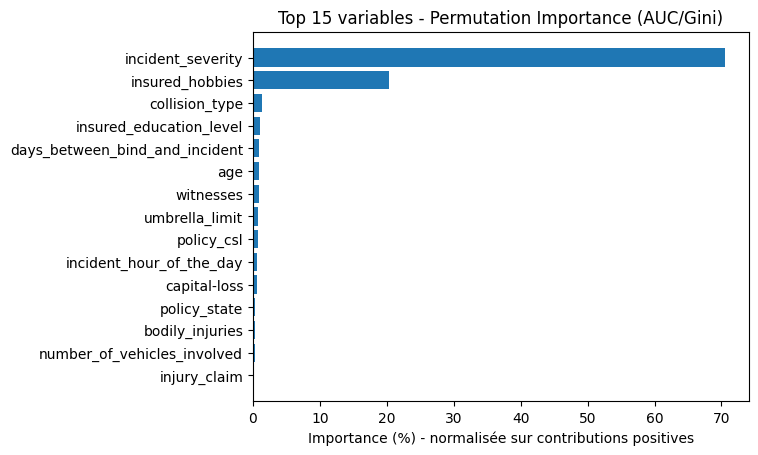

In [40]:
# Permutation importance (AUC/Gini) 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

#  Sécurité: vérifier que le modèle et les données existent 
# hgb : pipeline entraîné
# X_test, y_test : set de test
assert "hgb" in globals(), "Le pipeline 'hgb' n'existe pas. Entraîne d'abord le modèle."
assert "X_test" in globals() and "y_test" in globals(), "X_test / y_test manquent. Fais le split avant."
assert hasattr(hgb, "predict_proba"), "Le modèle doit avoir predict_proba."

# Score de référence (AUC/Gini) 
proba = hgb.predict_proba(X_test)[:, 1]
auc_ref = roc_auc_score(y_test, proba)
gini_ref = 2 * auc_ref - 1

print(f"AUC test (référence)  : {auc_ref:.6f}")
print(f"Gini test (référence) : {gini_ref:.6f}")

#  Permutation importance sur le set de test 
# importance = baisse moyenne de l'AUC quand on permute une variable (plus c'est grand, plus c'est important)
perm = permutation_importance(
    hgb, X_test, y_test,
    scoring="roc_auc",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

fi = pd.DataFrame({
    "feature": X_test.columns,
    "importance_auc_drop": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_auc_drop", ascending=False)

#  Correction des % 
# Parfois certaines importances sont négatives (permuter peut "améliorer" légèrement par hasard).
# Pour des % cohérents, on ne normalise que sur les contributions positives.
fi["importance_pos"] = fi["importance_auc_drop"].clip(lower=0)

total_pos = fi["importance_pos"].sum()

# Éviter division par zéro 
if total_pos == 0:
    fi["importance_pct"] = 0.0
else:
    fi["importance_pct"] = 100 * fi["importance_pos"] / total_pos

#  Affichage tableau 
display(fi[["feature", "importance_auc_drop", "importance_std", "importance_pct"]].head(20))

print("Somme des % (positifs) =", fi["importance_pct"].sum())

#  Graphique 
top_k = 15
top = fi.head(top_k).iloc[::-1]  # inversé pour un plot horizontal lisible

plt.figure()
plt.barh(top["feature"], top["importance_pct"])
plt.xlabel("Importance (%) - normalisée sur contributions positives")
plt.title(f"Top {top_k} variables - Permutation Importance (AUC/Gini)")
plt.show()


In [46]:
# Ablation test: ré-entraîner un HGB SANS incident_severity 


import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

#  On retire la feature
col_to_remove = "incident_severity"
X_train_no = X_train.drop(columns=[col_to_remove])
X_test_no  = X_test.drop(columns=[col_to_remove])

#  On recalcule les listes de colonnes num/cat (IMPORTANT)
num_cols_no = X_train_no.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
cat_cols_no = X_train_no.select_dtypes(include=["object", "string"]).columns.tolist()

#  On reconstruit le preprocess (adapté au nouveau X)
numeric_pipe_no = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe_no = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_no = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_no, num_cols_no),
        ("cat", categorical_pipe_no, cat_cols_no),
    ],
    remainder="drop"
)

#  Conversion sparse -> dense (nécessaire pour HGB)
to_dense = FunctionTransformer(lambda x: x.toarray() if hasattr(x, "toarray") else x)

# Nouveau pipeline modèle (indépendant du précédent)
hgb_no = Pipeline(steps=[
    ("preprocess", preprocess_no),
    ("to_dense", to_dense),
    ("model", HistGradientBoostingClassifier(random_state=42))
])

#  Entraînement + évaluation
hgb_no.fit(X_train_no, y_train)
proba_no = hgb_no.predict_proba(X_test_no)[:, 1]

auc_no = roc_auc_score(y_test, proba_no)
gini_no = 2 * auc_no - 1

try:
    auc_full = auc_ref
except NameError:
    auc_full = roc_auc_score(y_test, hgb.predict_proba(X_test)[:, 1])

gini_full = 2 * auc_full - 1

print("=== Comparaison ===")
print(f"AUC full  : {auc_full:.6f} | Gini full  : {gini_full:.6f}")
print(f"AUC sans {col_to_remove}: {auc_no:.6f} | Gini sans {col_to_remove}: {gini_no:.6f}")
print(f"Delta Gini (full - sans) : {(gini_full - gini_no):.6f}")


=== Comparaison ===
AUC full  : 0.828896 | Gini full  : 0.657792
AUC sans incident_severity: 0.576564 | Gini sans incident_severity: 0.153129
Delta Gini (full - sans) : 0.504663
